# Imports

In [2]:
import matplotlib.pyplot as plt
from hypertiling import HyperbolicTiling, TilingKernels
from hypertiling.graphics.plot import plot_tiling
from hypertiling.operators import adjacency
import networkx as nx
import numpy as np

c:\Users\17135\lattice_project\Hyperbolic_Lattices\hypertiling\check_numba.py:9: UserWarning: Failed to import numba... Use non-numba mode
  warnings.warn("Failed to import numba... Use non-numba mode")


# Create Hyperbolic Tiling Object

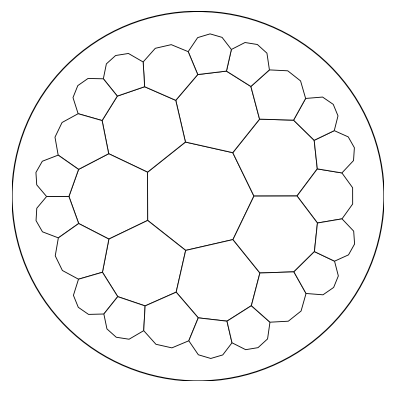

In [3]:
tiling = HyperbolicTiling(
    p=7, q=3, n=3,
    kernel=TilingKernels.StaticRotationalSector
)

plot_tiling(tiling, unitcircle=True, edgecolor="black", linewidth=0.5)
plt.show()

neighbors = tiling.get_nbrs_list(method="RO")

# Dual Graph and Spanning Tree

29


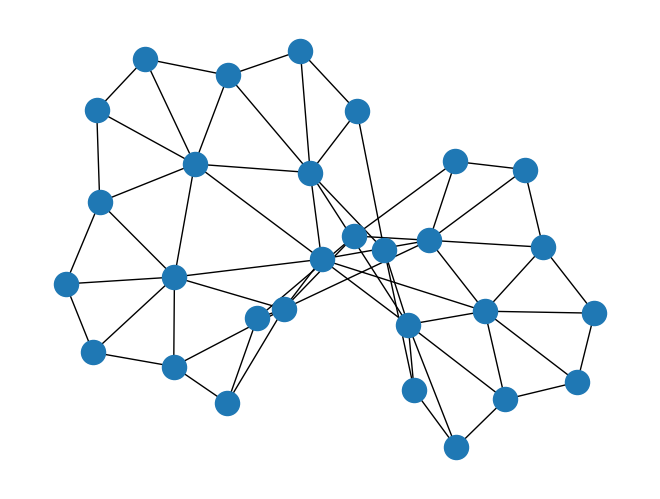

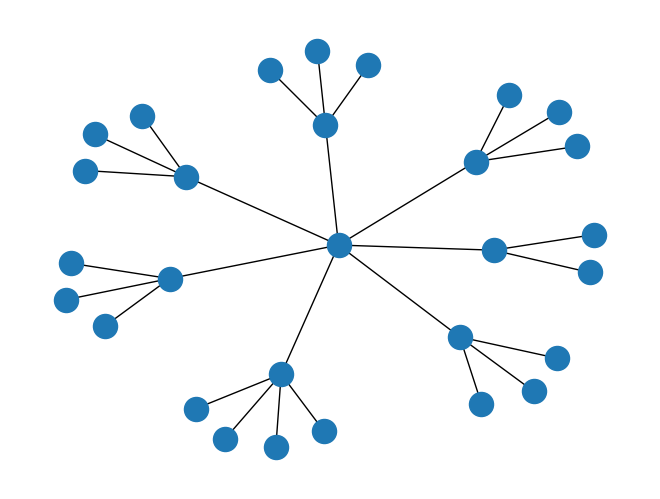

In [4]:
# Make a dual graph G corresponding to the tiling
V = len(tiling) # vertices = number of faces
print(V)
G = nx.Graph()
for u, nbrs in enumerate(neighbors):
    for v in nbrs:
        if u < v:
            G.add_edge(u, v)
nx.draw(G)
plt.show()

# Get a spanning tree of G
T = nx.minimum_spanning_tree(G) 
nx.draw(T)
plt.show()
tree_edges = set(T.edges()) 


# Index Tiling Faces

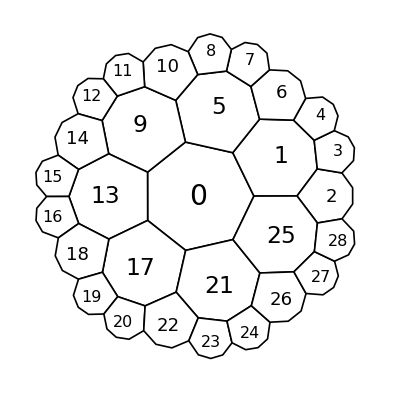

In [5]:
plot_tiling(tiling)
#layer_list = []
for poly in tiling.polygons:
    x, y = poly.get_center().real, poly.get_center().imag
    #layers = tiling.get_layer(poly)
    #layer_list.append(layers)
    plt.text(x, y, f"{poly.idx}", ha="center", va="center", fontsize=17*(1-0.7*np.abs(x*x+y*y)))
#print(layer_list)

# Notes

- need a way to make a list of each edge on the regular graph and find the intersections between the spanning tree 
- edges and the regular graph edges
- also need a way to take each face and find the regular graph edges that comprise the face cycle
- then we need to go back and figure out what multiplicities to assign to each spanning tree edge and also assign said multiplicity
- to the corresponding regular edge
- separately use coordinates to properly assign a sign -1 or +1 to each regular graph edge
- call this function within the multiplicity assigner for the regular graph and multiply with the sign
- call the multiplicities into the face cycles and then sum over everything + multiply by global phase
- this will be the total flux through the plaquette
- now check that this flux is equal to the global phase for each plaquette
- if correct, the adjacency matrix can be built and the butterfly should be accurate

# Extract Tiling Edges as a List

In [6]:
# First, we need to extract a list of edges for the regular tiling
edges = []
face_cycles = []
# iterate over cells
for poly in tiling:
    # extract vertex coordinates
    u = poly[1:]
    nv = len(u)
   
# loop over vertices/edges
    face_cycle_i = []
    for i in range(nv):
            # extract edges
            z1 = u[i]
            z2 = u[(i + 1) % 7]
            edge = (z1, z2)  
            face_cycle_i.append(edge)
    face_cycles.append(face_cycle_i)
    print((face_cycle_i))
#print((face_cycles))

#print(len(edges))
# this inherently uses the coordinates of each vertex - relate them to the indices i assigned for brevity
# these coordinates are also key for designating the +/- sign later 
# the length of each face cycle should be 7. 29 face cycles of 7 edges each for 203 edges total
# now I need to connect the edges contributing to each face cycle with the tuples based on the face index

[((0.3007419205951552+0.0006480178756849455j), (0.18700287970607574+0.23553353415610442j)), ((0.18700287970607574+0.23553353415610442j), (-0.06755314376524768+0.29305749520846863j)), ((-0.06755314376524768+0.29305749520846863j), (-0.27124027214833335+0.12990318508538537j)), ((-0.27124027214833335+0.12990318508538537j), (-0.270677943310499-0.13107087294905806j)), ((-0.270677943310499-0.13107087294905806j), (-0.0662896023360517-0.2933458902943042j)), ((-0.0662896023360517-0.2933458902943042j), (0.18801616125890078-0.23472546908228098j)), ((0.18801616125890078-0.23472546908228098j), (0.3007419205951552+0.0006480178756849455j))]
[((0.3007419205951552+0.0006480178756849455j), (0.5323811586257746+0.0011471380736834587j)), ((0.5323811586257746+0.0011471380736834587j), (0.6414738617025255+0.14786714794792635j)), ((0.6414738617025255+0.14786714794792635j), (0.6246124707519057+0.302457233105276j)), ((0.6246124707519057+0.302457233105276j), (0.513790827922822+0.4115487745482737j)), ((0.5137908279

# Match Spanning Tree Node Indices to that of Tiling Faces

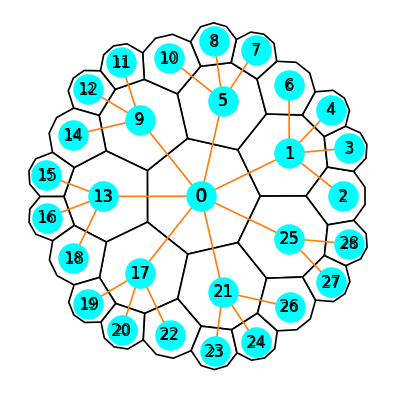

In [7]:
# Find a way to assign the vertices of the spanning tree the same index as the faces on the tiling 

# take the spanning tree and turn it into a graph object for the overlay
T_idx = nx.Graph()
for u, v in T.edges():
    T_idx.add_edge(u, v)

# for every face in the tiling, obtain the corresponding index
poly_map = { poly.idx: poly for poly in tiling.polygons }

# tiling plot for the overlay with the associated indices on each face like before
plot_tiling(tiling)
for i, poly in poly_map.items():
    x, y = poly.get_center().real, poly.get_center().imag
    plt.text(x, y, str(i),
             ha="center", va="center",
             fontsize=12*(1 - 0.5 * (x**2 + y**2)**0.5))
# take the index of every node in the spanning tree and map it to the
# corresponding index of the face in the tiling
# account for the position of these numbers on the spanning tree for visual purposes
pos = { id: (poly_map[id].get_center().real,
               poly_map[id].get_center().imag)
        for id in T_idx.nodes() }
# plot the overlay of the tiling with the spanning tree - the indices of the faces and nodes match
nx.draw(T_idx, pos=pos,
        with_labels=True,
        node_color="cyan",
        edge_color="C1",
        font_size=10)

plt.axis("equal")
plt.show()


# Notes

In [124]:
# Now, I need to recursively define multiplicities associated with each edge of the spanning tree
# Then, I need to make sure that these multiplicities are associated with the right tiling edge
# After that, I need to pass that information into the face cycles so that I can obtain flux per plaquette

# Match Node/Face Indices to the Corresponding Layer of the Tiling 

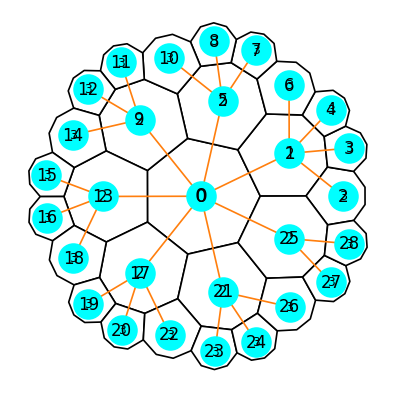

[0, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[(0, 0), (2, 1), (3, 2), (3, 3), (3, 4), (2, 5), (3, 6), (3, 7), (3, 8), (2, 9), (3, 10), (3, 11), (3, 12), (2, 13), (3, 14), (3, 15), (3, 16), (2, 17), (3, 18), (3, 19), (3, 20), (2, 21), (3, 22), (3, 23), (3, 24), (2, 25), (3, 26), (3, 27), (3, 28)]


In [8]:
T_idx = nx.Graph()
for u, v in T.edges():
    T_idx.add_edge(u, v)

poly_map = { poly.idx: poly for poly in tiling.polygons }

layers_list = []
poly_list = []
plot_tiling(tiling)
for i, poly in poly_map.items():
    x, y = poly.get_center().real, poly.get_center().imag
    l = tiling.get_layer(i)
    layers_list.append(l)
    poly_list.append(i)
    plt.text(x, y, str(l),
             ha="center", va="center",
             fontsize=12*(1 - 0.5 * (x**2 + y**2)**0.5))

pos = { id: (poly_map[id].get_center().real,
               poly_map[id].get_center().imag)
        for id in T_idx.nodes() }
# plot the overlay of the tiling with the spanning tree - the indices of the layers match
nx.draw(T_idx, pos=pos,
        with_labels=True,
        node_color="cyan",
        edge_color="C1",
        font_size=10)

plt.axis("equal")
plt.show()

print(layers_list)
print(poly_list)
layer_plus_poly = list(zip(layers_list, poly_list))
print(layer_plus_poly)


# Multiplicity Attempt 1

In [9]:
# consider every node from layer 3. each edge of ST with that node will have a multiplicity of 1. 
# since the idx of the node corresponds to the idx of the regular face, we then need to find the edge
# of the regular graph between the faces and assign that a multiplicity of 1

updated_layer_plus_poly = {}

for element in layer_plus_poly:
    if element[0] == 3:
        multiplicity = (1,)
        updated_layer_plus_poly[element] = element + multiplicity
    else:
        updated_layer_plus_poly[element] = element  # preserve others unchanged

# Print updated entries
for k, v in updated_layer_plus_poly.items():
    print(f"{k} -> {v}")


(0, 0) -> (0, 0)
(2, 1) -> (2, 1)
(3, 2) -> (3, 2, 1)
(3, 3) -> (3, 3, 1)
(3, 4) -> (3, 4, 1)
(2, 5) -> (2, 5)
(3, 6) -> (3, 6, 1)
(3, 7) -> (3, 7, 1)
(3, 8) -> (3, 8, 1)
(2, 9) -> (2, 9)
(3, 10) -> (3, 10, 1)
(3, 11) -> (3, 11, 1)
(3, 12) -> (3, 12, 1)
(2, 13) -> (2, 13)
(3, 14) -> (3, 14, 1)
(3, 15) -> (3, 15, 1)
(3, 16) -> (3, 16, 1)
(2, 17) -> (2, 17)
(3, 18) -> (3, 18, 1)
(3, 19) -> (3, 19, 1)
(3, 20) -> (3, 20, 1)
(2, 21) -> (2, 21)
(3, 22) -> (3, 22, 1)
(3, 23) -> (3, 23, 1)
(3, 24) -> (3, 24, 1)
(2, 25) -> (2, 25)
(3, 26) -> (3, 26, 1)
(3, 27) -> (3, 27, 1)
(3, 28) -> (3, 28, 1)


# Notes

In [145]:
# For each face cycle, we can describe the associated edges via the coordinates of the tiling's vertices
# We need to then find out the index of the two faces on either side of each of the face cycle edges
# For example, if E1 is an edge in the regular tiling and is part of the face cycle for both face 1 and face 3
# then I know that faces 1 and 3 are adjacent and there must exist an edge on the dual graph such that it is
# described by nodes 1 and 3 (ie. we pick out edge (1,3) or (3,1)). 
# this means we can correlate the tiling edges to dual graph edges within a list of tuples
# then iterate through each combination to build a new list that only contains tuples where the dual graph edge
# component is ALSO part of the spanning tree
# this new list will have tuples containing BOTH the edges of the spanning tree 
# and the edges of the tiling which they intersect with

# suppose we have another function that assigns a value to each spanning tree edge and multiplies it by phi
# now it would be easy to relate that information to the tiling edges by adding an element to the tuples
# each component of the list would now look like (tiling edge, ST edge, #phi)
# then somehow rebuild the face cycles including the #phi value
# sum over all #phi for each face cycle
# verify that the total matches for all face cycles
# build hamiltonian and butterfly

In [146]:
# since each tiling edge is written in terms of the coordinates of the vertices, 
# there should be a way to find the neighbors of each edge? - check package
# then, I should be able to figure out which faces are being glued together by each edge

# need a pandas data frame to store all this information because it's way too much stuff overall 

The information I need/have:

- list of the faces (their index)
- each face cycle
- list of the spanning tree nodes (indexed the same way as the faces)
- which layer each face belongs to
- the value associated with each spanning tree edge
- list of all the spanning tree edges
- list of all the dual graph edges (this information does not need to be stored permanently)


# Add Root to Spanning Tree

Graph with 30 nodes and 29 edges


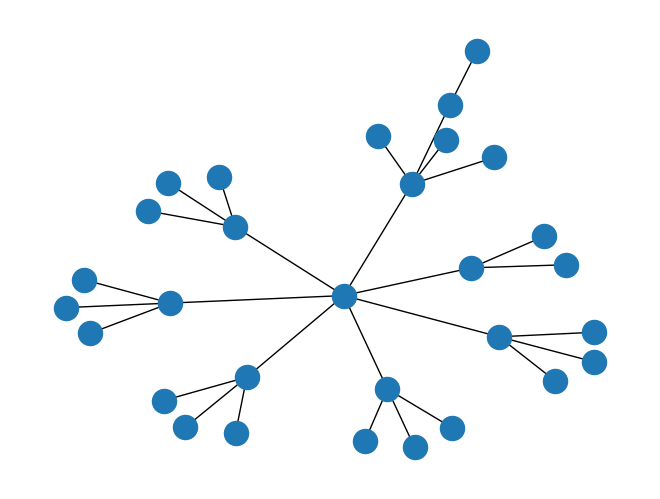

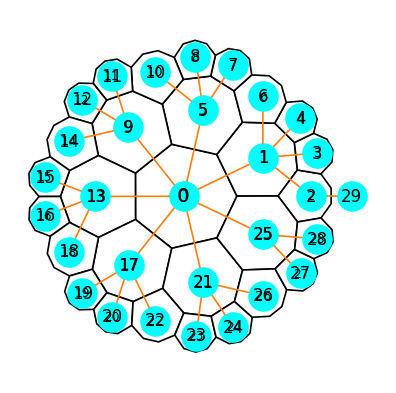

In [28]:
# Make a dual graph G corresponding to the tiling
V = len(tiling) # vertices = number of faces
root_point = V

# p determines the number of edges each polygon face has, and every face will have p neighbors
# however, the faces on the outer ring will have p-1 neighbors, so if nbrs < p, said face is on the boundary
outermost_faces = []
for u, nbrs in enumerate(neighbors):
    if len(nbrs) < tiling.p:
        outermost_faces.append(u)
root_face = outermost_faces[0]

# Get a spanning tree of G
T_rooted = nx.minimum_spanning_tree(G)

T_rooted.add_edge(root_face, root_point)
tree_edges_rooted = set(T_rooted.edges()) 
print(T_rooted)
nx.draw(T_rooted)
plt.show()

# take the spanning tree and turn it into a graph object for the overlay
T_idx = nx.Graph()
for u, v in T_rooted.edges():
    T_idx.add_edge(u, v)

# for every face in the tiling, obtain the corresponding index
poly_map = { poly.idx: poly for poly in tiling.polygons }

# tiling plot for the overlay with the associated indices on each face like before
plot_tiling(tiling)
for i, poly in poly_map.items():
    x, y = poly.get_center().real, poly.get_center().imag
    plt.text(x, y, str(i),
             ha="center", va="center",
             fontsize=12*(1 - 0.5 * (x**2 + y**2)**0.5))
# take the index of every node in the spanning tree and map it to the
# corresponding index of the face in the tiling
# account for the position of these numbers on the spanning tree for visual purposes

pos = {node: (poly_map[node].get_center().real,
              poly_map[node].get_center().imag)
       for node in T_idx.nodes() if node in poly_map}

# now add the outside node explicitly
max_r = max(abs(poly.get_center()) for poly in tiling.polygons)
pos[root_point] = (1.2 * max_r, 0)

# plot the overlay of the tiling with the spanning tree - the indices of the faces and nodes match
nx.draw(T_idx, pos=pos,
        with_labels=True,
        node_color="cyan",
        edge_color="C1",
        font_size=10)

plt.axis("equal")
plt.show()

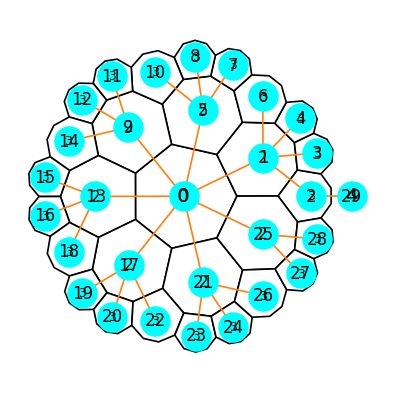

[0, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 4]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[(0, 0), (2, 1), (3, 2), (3, 3), (3, 4), (2, 5), (3, 6), (3, 7), (3, 8), (2, 9), (3, 10), (3, 11), (3, 12), (2, 13), (3, 14), (3, 15), (3, 16), (2, 17), (3, 18), (3, 19), (3, 20), (2, 21), (3, 22), (3, 23), (3, 24), (2, 25), (3, 26), (3, 27), (3, 28), (4, 29)]


In [19]:
T_idx = nx.Graph()
for u, v in T_rooted.edges():
    T_idx.add_edge(u, v)

poly_map = { poly.idx: poly for poly in tiling.polygons }

layers_list = []
poly_list = []
plot_tiling(tiling)
for i, poly in poly_map.items():
    x, y = poly.get_center().real, poly.get_center().imag
    l = tiling.get_layer(i)
    layers_list.append(l)
    poly_list.append(i)
    plt.text(x, y, str(l),
             ha="center", va="center",
             fontsize=12*(1 - 0.5 * (x**2 + y**2)**0.5))

pos = {node: (poly_map[node].get_center().real,
              poly_map[node].get_center().imag)
       for node in T_idx.nodes() if node in poly_map}

# now add the outside node explicitly
max_r = max(abs(poly.get_center()) for poly in tiling.polygons)
pos[root_point] = (1.2 * max_r, 0)

outer_layer = tiling.n + 1
layers_list.append(outer_layer)
poly_list.append(root_point)

x, y = pos[root_point]
plt.text(x, y, str(outer_layer),
         ha="center", va="center",
         fontsize=12)

# plot the overlay of the tiling with the spanning tree - the indices of the layers match
nx.draw(T_idx, pos=pos,
        with_labels=True,
        node_color="cyan",
        edge_color="C1",
        font_size=10)

plt.axis("equal")
plt.show()

print(layers_list)
print(poly_list)
layer_plus_poly = list(zip(layers_list, poly_list))
print(layer_plus_poly)

In [ ]:
import pandas as pd

faces_nodes_layers_df = pd.DataFrame({
    "Tiling Faces/ST Nodes Index": poly_list,
    "Layer": layers_list
})

print(faces_nodes_layers_df)


    Tiling Faces/ST Nodes Index  Layer
0                             0      0
1                             1      2
2                             2      3
3                             3      3
4                             4      3
5                             5      2
6                             6      3
7                             7      3
8                             8      3
9                             9      2
10                           10      3
11                           11      3
12                           12      3
13                           13      2
14                           14      3
15                           15      3
16                           16      3
17                           17      2
18                           18      3
19                           19      3
20                           20      3
21                           21      2
22                           22      3
23                           23      3
24                       

In [ ]:
print(tree_edges_rooted)
df = pd.DataFrame(tree_edges_rooted)
print(df)

{(5, 7), (5, 10), (0, 5), (9, 14), (9, 11), (1, 6), (1, 3), (0, 17), (25, 28), (2, 29), (21, 24), (0, 1), (1, 2), (17, 20), (0, 13), (13, 16), (0, 25), (25, 27), (21, 23), (21, 26), (5, 8), (9, 12), (0, 9), (17, 19), (1, 4), (17, 22), (0, 21), (13, 18), (13, 15)}
     0   1
0    5   7
1    5  10
2    0   5
3    9  14
4    9  11
5    1   6
6    1   3
7    0  17
8   25  28
9    2  29
10  21  24
11   0   1
12   1   2
13  17  20
14   0  13
15  13  16
16   0  25
17  25  27
18  21  23
19  21  26
20   5   8
21   9  12
22   0   9
23  17  19
24   1   4
25  17  22
26   0  21
27  13  18
28  13  15


In [ ]:
# ok now for the function assigning values to each spanning tree edge

multiplicities = {}
for element in tree_edges_rooted:
    if element[1] in outermost_faces: # the outer face connected to the root is by def excluded from that list
        multiplicity = (1,)
        multiplicities[element] = element + multiplicity
    elif element[1] :
        for element in layer_plus_poly:
            if element[0] == 2:
                multiplicity = (8,)
                updated_layer_plus_poly[element] = element + multiplicity
            else:
                updated_layer_plus_poly[element] = element  # preserve others unchanged









(5, 7) -> (5, 7, 1)
(5, 10) -> (5, 10, 1)
(0, 0) -> (0, 0)
(2, 1) -> (2, 1, 8)
(3, 2) -> (3, 2)
(3, 3) -> (3, 3)
(3, 4) -> (3, 4)
(2, 5) -> (2, 5, 8)
(3, 6) -> (3, 6)
(3, 7) -> (3, 7)
(3, 8) -> (3, 8)
(2, 9) -> (2, 9, 8)
(3, 10) -> (3, 10)
(3, 11) -> (3, 11)
(3, 12) -> (3, 12)
(2, 13) -> (2, 13, 8)
(3, 14) -> (3, 14)
(3, 15) -> (3, 15)
(3, 16) -> (3, 16)
(2, 17) -> (2, 17, 8)
(3, 18) -> (3, 18)
(3, 19) -> (3, 19)
(3, 20) -> (3, 20)
(2, 21) -> (2, 21, 8)
(3, 22) -> (3, 22)
(3, 23) -> (3, 23)
(3, 24) -> (3, 24)
(2, 25) -> (2, 25, 8)
(3, 26) -> (3, 26)
(3, 27) -> (3, 27)
(3, 28) -> (3, 28)
(4, 30) -> (4, 30)
(9, 14) -> (9, 14, 1)
(9, 11) -> (9, 11, 1)
(1, 6) -> (1, 6, 1)
(1, 3) -> (1, 3, 1)
(25, 28) -> (25, 28, 1)
(21, 24) -> (21, 24, 1)
(1, 2) -> (1, 2, 1)
(17, 20) -> (17, 20, 1)
(13, 16) -> (13, 16, 1)
(25, 27) -> (25, 27, 1)
(21, 23) -> (21, 23, 1)
(21, 26) -> (21, 26, 1)
(5, 8) -> (5, 8, 1)
(9, 12) -> (9, 12, 1)
(17, 19) -> (17, 19, 1)
(1, 4) -> (1, 4, 1)
(17, 22) -> (17, 22, 1)
(13, 